<a href="https://colab.research.google.com/github/Ritaban26/Content-Recommender-Engine/blob/main/Content_Recommender_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎵 Project: Neural Music Recommendation Engine
**Author:** Ritaban Biswas

**Dataset:** Last.fm 360K (Implicit Feedback)  

**Goal:** Build a recommender system to suggest music artists based on listening history.

---

## 📚 Table of Contents
*Click a link to jump to that section:*
1. [Setup & Data Loading](#setup)
2. [Data Preprocessing (Log Normalization)](#preprocessing)
3. [Exploratory Data Analysis (EDA)](#eda)
4. [Dataset & DataLoaders](#dataset)
5. [Model Architecture (Matrix Factorization)](#model)
6. [Training Loop](#training)

In [2]:
# ⬇️ 1. Download Data (Run Once per Session)
# We fetch the Last.fm 360K dataset directly from the source
!wget -q --show-progress http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-360K.tar.gz
!tar -xzf lastfm-dataset-360K.tar.gz

# Import the PyTorch Ecosystem
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim # <--- Contains Adam & SGD
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset


# Check for GPU (Essential for training speed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using Device: {device}")

lastfm-dataset-360K 100%[===================>] 542.83M   820KB/s    in 10m 50s 
🚀 Using Device: cuda


<a id="preprocessing"></a>
## 2. Data Preprocessing
Here we handle the "Implicit Feedback" challenge.
1. **Load TSV:** The data is Tab-Separated.
2. **Filter:** Remove artists with < 50 listeners to prevent RAM crashes.
3. **Log Normalization:** Convert raw "Play Counts" (1-100k) into a "Rating Score" (0-10 scale).
4. **ID Mapping:** Convert String IDs (Artist Names) to Integer Indices (0, 1, 2...).

In [3]:
# ⬇️ 2. Load and Clean Data
print("⏳ Loading Music Data... (Please wait)")
headers = ['user_id', 'artist_id', 'artist_name', 'plays']
incoming_df = pd.read_csv(
    'lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv',
    sep='\t',
    header=None,
    names=headers,
    on_bad_lines='skip'
)

# 📉 Filter: Keep artists with > 50 unique listeners
# This prevents RAM crashes by removing obscure data
popular_artists = incoming_df.groupby('artist_name').filter(lambda x: len(x) > 50)
df = popular_artists.copy()

# 🛠️ Log Normalization
# Convert "10,000 plays" -> "9.2 rating" using Logarithm
df['rating'] = np.log1p(df['plays'])

# 🛠️ ID Mapping
# Convert String IDs to Integers (0, 1, 2...) for the Model
user_ids = df['user_id'].unique().tolist()
artist_ids = df['artist_name'].unique().tolist()

user_map = {x: i for i, x in enumerate(user_ids)}
artist_map = {x: i for i, x in enumerate(artist_ids)}

df['user_encoded'] = df['user_id'].map(user_map)
df['artist_encoded'] = df['artist_name'].map(artist_map)

num_users = len(user_map)
num_artists = len(artist_map)

print(f"✅ Data Loaded: {num_users} Users, {num_artists} Artists")
print(f"Rating Scale: {df['rating'].min():.2f} - {df['rating'].max():.2f}")

⏳ Loading Music Data... (Please wait)
✅ Data Loaded: 358827 Users, 26026 Artists
Rating Scale: 0.69 - 12.95


<a id="eda"></a>
## 2.1 Exploratory Data Analysis (EDA)
We visualize the data to confirm our normalization worked.
* **Histogram:** Should look like a "Hill" or Bell Curve.
* **Bar Chart:** Shows the most popular artists in the dataset.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

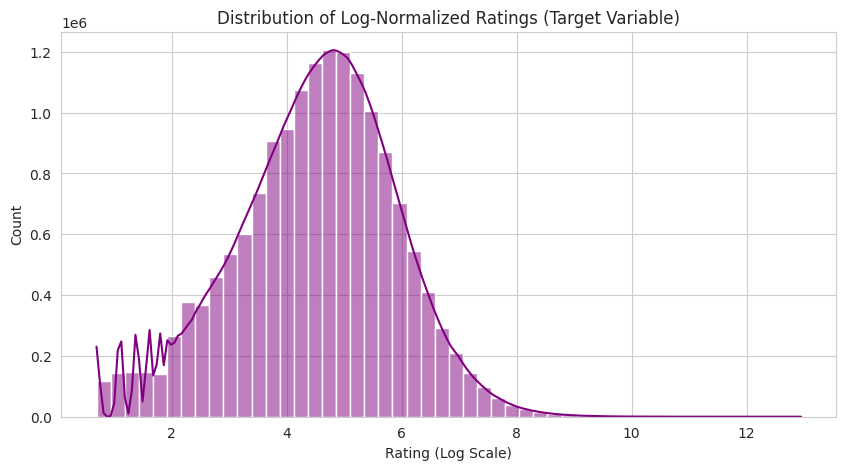

/tmp/ipython-input-454213230.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis')


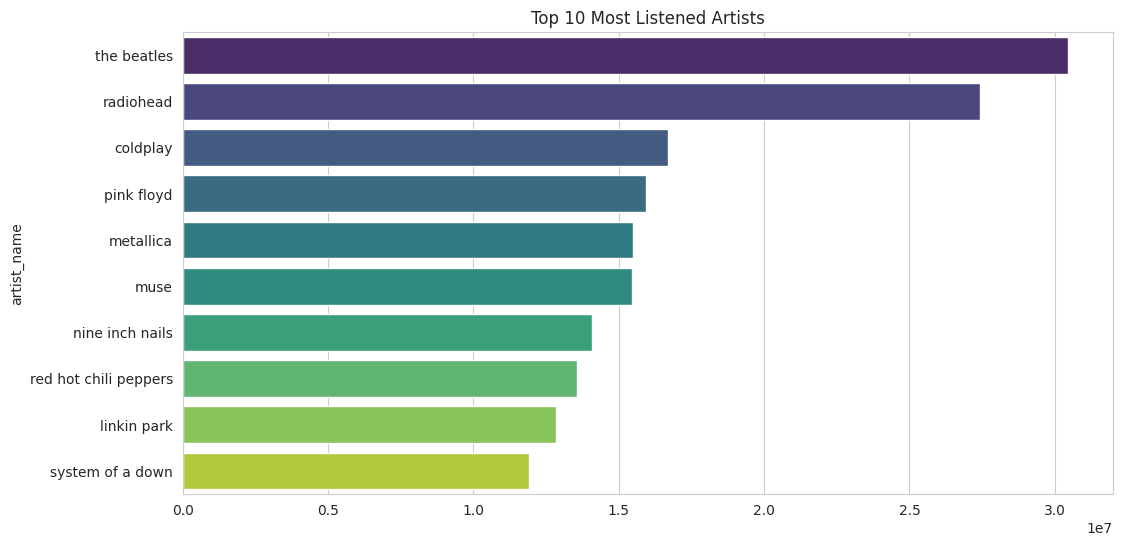

In [5]:
# ⬇️ 2.1 Visualize
sns.set_style("whitegrid")

# Plot 1: Rating Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['rating'], bins=50, kde=True, color='purple')
plt.title('Distribution of Log-Normalized Ratings (Target Variable)')
plt.xlabel('Rating (Log Scale)')
plt.show()

# Plot 2: Top Artists
plt.figure(figsize=(12, 6))
top_artists = df.groupby('artist_name')['plays'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis')
plt.title('Top 10 Most Listened Artists')
plt.show()

<a id="dataset"></a>
## 3. Dataset & DataLoaders
We wrap the Pandas DataFrame into a PyTorch `Dataset`.
Then we use `DataLoader` to shuffle and batch the data (256 rows at a time) for the Optimizer.

In [6]:
# ⬇️ 3. PyTorch Data Setup
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

class MusicDataset(Dataset):
    def __init__(self, users, artists, ratings):
        self.users = torch.tensor(users, dtype=torch.long)
        self.artists = torch.tensor(artists, dtype=torch.long)
        self.ratings = torch.tensor(ratings, dtype=torch.float32)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, item):
        return self.users[item], self.artists[item], self.ratings[item]

# Create DataLoaders
train_dataset = MusicDataset(
    train_df['user_encoded'].values,
    train_df['artist_encoded'].values,
    train_df['rating'].values
)

# Batch Size 256 is efficient for this larger dataset
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
print("✅ DataLoaders Ready!")

✅ DataLoaders Ready!


<a id="model"></a>
## 4. Model Architecture (Matrix Factorization)
We define the Neural Network structure manually using `nn.Module`.
* **Embeddings:** Two lookup tables (User Vector & Artist Vector).
* **Forward Pass:** We explicitly calculate the Dot Product `(User * Artist).sum()`.

In [7]:
# ⬇️ 4. Define the Model Structure
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=32):
        super(MatrixFactorization, self).__init__()

        # 🧠 The Embeddings (The Learning Layers)
        # We use pre-built nn.Embedding to handle the lookup table logic
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.item_embedding = nn.Embedding(num_items, embedding_size)

        # Initialization (Small random numbers)
        self.user_embedding.weight.data.uniform_(0, 0.05)
        self.item_embedding.weight.data.uniform_(0, 0.05)

    def forward(self, user, item):
        # 1. Lookup the vectors
        user_vec = self.user_embedding(user)
        item_vec = self.item_embedding(item)

        # 2. Interaction (Dot Product)
        # Multiply vectors element-wise, then sum them up
        interaction = (user_vec * item_vec).sum(1)

        return interaction

<a id="training"></a>
## 5. Training Loop
Here we define the **Loss Function** and **Optimizer**.
* **Loss:** `MSELoss` (Mean Squared Error) because we are predicting a continuous rating.
* **Optimizer:** `Adam` (Adaptive Moment Estimation) to update weights efficiently.

In [8]:
# ⬇️ 5. Setup Training Logic

# Initialize Model
model = MatrixFactorization(num_users, num_artists, embedding_size=32)
model.to(device)

# 📉 Define Loss Function (MSE)
criterion = nn.MSELoss()

# ⚙️ Define Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ⬇️ 6. Run Training
epochs = 5
print("🚀 Starting Training...")

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for user, artist, rating in train_loader:
        # Move batch to GPU
        user, artist, rating = user.to(device), artist.to(device), rating.to(device)

        # A. Clear Gradients
        optimizer.zero_grad()

        # B. Forward Pass (Make a guess)
        prediction = model(user, artist)

        # C. Calculate Loss (Error)
        loss = criterion(prediction, rating)

        # D. Backward Pass (Calculus)
        loss.backward()

        # E. Step (Update Weights)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")

print("✅ Training Complete!")

🚀 Starting Training...
Epoch 1/5 | Loss: 2.5443
Epoch 2/5 | Loss: 0.6971
Epoch 3/5 | Loss: 0.6760
Epoch 4/5 | Loss: 0.6575
Epoch 5/5 | Loss: 0.6271
✅ Training Complete!


## 6. Evaluation & Sanity Check
Now that the model is trained, we need to verify it.
1. **Plot Loss:** Did the error decrease over time? (It should go down).
2. **Inference:** We verify the model by asking it to recommend songs for a random user.